Import all package

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yfin
import sqlite3 as sql
import pandas as pd
import pandas_datareader as pdr
import threading
import time
import os

Tickers

In [15]:
#array with all the studied currencies (yahoo finance currency names)
currencies = ["BTC-USD","ETH-USD","TTE.PA","ROK3.L","PREM.L"] 

YFianance API

In [16]:
### Function getMetaData
## Summary  get the meta information for a Ticker (currency)
## Params : { @s }
# @s : str ~> name of the Ticker
## Return : dict ~> meta information of the Ticker, the dict is the following : 
#           symbol : str ~> name online (yahoo finance) of the stock (is also the ticker name used by the yfinance API)
#           instrumentType : str ~> type of stock, can be a cryptocurrency ,  a stock ...
#           regularMarketTime int : ~> date when those informatation has been gathered in epoch/unix time 
#           gmtoffset int : ~> number of second of offset between the stock's market timezome and the gtm timzome
#           timezone str : ~> name of the stock's market timezone
# other var a disponnible but not used here (see yfinance documentation) 
def getMetaData(s : str) -> dict :
    ticker = yfin.Ticker(s)
    ticker.history()
    meta = ticker.history_metadata
    return meta

### Function getHistoryData
## Summary : get all the information since the creation of the Ticker (currency)
## Params : { @s }
# @s : str ~> name of the Ticker
## Return : dict ~> all the  informmation of the Ticker since creation, the dict contaign the following information :
#  for each day : Date : date ~> date of the information present
#                 Open : float ~> value of the stock when the market open
#                 High : float ~> highest value reach by the stock during the market time 
#                 Low : float ~> lowest value reach by the stock during the market time
#                 Close : float ~> value of the stock when the market close 
#                 Volume : float ~> total of stock sells during the market time 
def getHistoryData(s : str) -> dict :
    ticker = yfin.Ticker(s)
    data = ticker.history("max", interval = '1d')
    data['Date'] = data.index
    data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

### Function getHistoryData
## Summary : get the information of the Ticker for a certain period
## Params : { @s , @period}
# @s : str ~> name of the Ticker
# @period : str ~> duration of the period , the information period get are ending to the current day and start a period back
#                  can take value like {1d , 5d , 1m , 1y , ...}
## Return : dict ~> all the  information of the Ticker for the period, the dict contaign the following information :
#  for each day : Date : date ~> date of the information present
#                 Open : float ~> value of the stock when the market open
#                 High : float ~> highest value reach by the stock during the market time 
#                 Low : float ~> lowest value reach by the stock during the market time
#                 Close : float ~> value of the stock when the market close 
#                 Volume : float ~> total of stock sells during the market time 
def getPeriodData(s : str , period : str) -> dict :
    ticker = yfin.Ticker(s)
    data = ticker.history(period = period ,interval = '1d')
    data['Date'] = data.index
    data = data[["Date", "Open", "High","Low", "Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

Currency Table with meta data

In [67]:
### Function createCurrencyMetadataTable
## Summary : erase the currency table if it already exists and then create a new currency table 
def createCurrencyMetadataTable():
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    requestDrop = '''DROP TABLE IF EXISTS CURRENCIES_METADATA'''

    requestCreate = '''CREATE TABLE CURRENCIES_METADATA (
        [currencyId] INTEGER PRIMARY KEY AUTOINCREMENT,
        [currencyName] TEXT, 
        [instrumentType] TEXT,
        [regularMarketTime] INT,
        [gtmOffset] INT,
        [timezone] TEXT
        )'''
#currencyName : str ~> name online (yahoo finance) of the stock (is also the ticker name used by the yfinance API)
#instrumentType : str ~> type of stock, can be a cryptocurrency ,  a stock ...
#regularMarketTime int : ~> date when those informatation has been gathered in epoch/unix time 
#gtmOffset int : ~> number of second of offset between the stock's market timezome and the gtm timzome
#timezone str : ~> name of the stock's market timezone
    c.execute(requestDrop) # delete the table if it already exists 
    c.execute(requestCreate) # create a new currency table
    db.commit()

### Function getCurrencyMetadataElement
## Summary : get an element of the currency table by its id 
## Params : { @currencyId }
# @currencyId : int ~> id of the currency in the table 
## Return : dict ~> return the element as a dict
def getCurrencyMetadataElement(currencyId : int) -> dict :
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''SELECT * FROM CURRENCIES_METADATA WHERE currencyId='{currencyId}' '''
    c.execute(request)
    return c.fetchone()

### Function getIdByNameCurrencyMetadata
## Summary : get an element id of the currency table by its name 
## Params : { @currencyName }
# @currencyName : str ~> name of the stock 
## Return : int ~> return the element id
def getIdByNameCurrencyMetadata(currencyName: str) -> int :
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''SELECT currencyId FROM CURRENCIES_METADATA WHERE currencyName='{currencyName}' '''
    c.execute(request)
    return c.fetchone()[0]

### Function printCurrencyMetadataElement
## Summary : print an element of the currency table by its id 
## Params : { @currencyId }
# @currencyId : int ~> id of the currency in the table 
def printCurrencyMetadataElement(currencyId : int):
    metaData = getCurrencyMetadataElement(currencyId)
    header = f"-------- MetaData for {metaData[1]} --------"
    nHeader = len(header)
    print(header)
    print(f"\nName : {metaData[1]}")
    print(f"ID : {metaData[0]}")
    print(f"instrumentType : {metaData[2]}")
    print(f"regularMarketTime : {metaData[3]}")
    print(f"gtmOffset : {metaData[4]}")
    print(f"timezone : {metaData[5]}")
    footer = "\n"
    for i in range(nHeader): footer += "-"
    print(footer)

### Function insertCurrencyMetadataElement
## Summary : insert a new  element in the currency table 
## Params : { @currency }
# @currency : str ~> name of the currency to fetch its metadata with the yFinance API
def insertCurrencyMetadataElement(currency : str):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    metaData = getMetaData(currency)
    request = f'''INSERT INTO CURRENCIES_METADATA (currencyName,instrumenttype,regularMarketTime,gtmOffset,timezone)
        VALUES (
        '{metaData['symbol']}',
        '{metaData['instrumentType']}',
        {metaData['regularMarketTime']},
        {metaData['gmtoffset']},
        '{metaData['timezone']}')'''
    c.execute(request)
    db.commit()

### Function modifyCurrencyMetadataElement
## Summary : modify an element in the currency table, the element to modify must be enteriely rewrite 
## Params : { @currency>Id , @newMetaData }
# @currencyid : int  ~> id of the currency to modify in the currency table
# @newMetaData : dict ~> disctionnary contaigning all the information of the currency evan the ones not changed
def modifyCurrencyMetadataElement(currencyId : int, newMetaData : dict):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    #All the information MUST be given in the newMetaData dict even the id and the ones not changed
    request = f'''UPDATE CURRENCIES_METADATA 
        SET 
        currencyId={newMetaData['currencyId']},
        currencyName='{newMetaData['symbol']}', 
        instrumentType='{newMetaData['instrumentType']}', 
        regularMarketTime={newMetaData['regularMarketTime']},
        gtmOffset={newMetaData['gtmOffset']},
        timezone='{newMetaData['timezone']}' 
        WHERE currencyId = {currencyId}'''
    c.execute(request)
    db.commit()

### Function deleteCurrencyMetadataElement
## Summary : delete an element from the currency table,
## Params : { @currency>Id }
# @currencyid : int  ~> id of the currency to delete from the currency table
def deleteCurrencyMetadataElement(currencyId : int):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''DELETE FROM CURRENCIES_METADATA
        WHERE currencyId = {currencyId}'''
    c.execute(request)
    db.commit()


Market Table

In [58]:
### Function cleanNameForSQL
## Summary : return a new string that dont contaign special char to use it as sql table name
## Params : { @s }
# @s : str ~> s where to remove special char 
## Return : str ~> entry string without special char nor spaces 
def cleanNameForSQL(s :str) -> str:
    for char in ['-','.','^',' ']:
            s = s.replace(char,"")
    return s

### Function createCurrencyMarketTable
## Summary : create a new table if it dont alredy exist to contaign all the market infomation of a currency
## Params : { @currencyName }
# @currencyName : str ~> name of the currency for which a new table is created 
def createCurrencyMarketTable(currencyName : str):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currencyName)
    #each lign in the table represent a new day and contaign :
    #   Date : date ~> date of the information present
    #   Open : float ~> value of the stock when the market open
    #   High : float ~> highest value reach by the stock during the market time 
    #   Low : float ~> lowest value reach by the stock during the market time
    #   Close : float ~> value of the stock when the market close 
    #   Volume : float ~> total of stock sells during the market time 
    createNewCurrencyTable = f'''CREATE TABLE IF NOT EXISTS {tableName}_MARKET 
    ([Id] INTEGER PRIMARY KEY AUTOINCREMENT,
    [Date] TEXT,
    [Open] NUMBER,
    [High] NUMBER,
    [Low] NUMBER,
    [Close] NUMBER,
    [Volume] NUMBER)'''
    c.execute(createNewCurrencyTable)
    db.commit()

### Function fillCurrencyMarketTable
## Summary : fill a currency market table with its information 
## Params : { @currency , @period }
# @currency : str ~> yahoo finance name of the currency , used to get the information with the API
# @period : str ~> default value is none : all the information since create are fetched, can be defined to limit the period (for value value autorized see yfinance doc)
def fillCurrencyMarketTable(currency : str , period : str = None):
    db = sql.connect("mydatabase.db")
    c = db.cursor()

    tableName = cleanNameForSQL(currency)
    requestTemplate = f'''INSERT INTO {tableName}_MARKET (Date,Open,High,Low,Close,Volume)
        VALUES  '''

    #verify if @period has been enter as parameter
    if period : data = getPeriodData(currency , period)  #if yes get only period data
    else : data = getHistoryData(currency) # else get all data since creation

    #for each lign in data fetched, the request add them in the table
    for i in range(len(data)):
        line = data.iloc[i]
        #round(line[2:5],13) #all number are rounded to the 13th decimal to avoid some float type python issues  
        request =requestTemplate + f'''('{line['Date']}',
        {line['Open']},
        {line['High']},
        {line['Low']},
        {line['Close']},
        {line['Volume']});'''

        c.execute(request)
    db.commit()

### Function getCurrencyMarketElement
## Summary : get an from a currency market table by its id 
## Params : { @currency , @elementId }
# @currency : str ~> yahoo finance name of the currency , used to get the information with the API
# @elementId : int ~> id of the element to get 
## Return : dict ~> element of the table which id is elementId 
def getCurrencyMarketElementById(currency : str , elementId : int ) -> dict :
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT * FROM {tableName}_MARKET WHERE Id = {elementId}  '''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    return c.fetchone()

### Function insertCurrencyMarketElement
## Summary : insert a new currency market element in the corresponding table 
## Params : { @currency , @element }
# @currency : str ~> yahoo finance name of the currency
# @element : dict ~> new element to add in the table , this dict must contaign definition for {Date,Open,Hight,Low,Close,Volume}
def insertCurrencyMarketElement(currency : str, element : dict):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currency)
    request = f'''INSERT INTO {tableName}_MARKET (Date,Open,High,Low,Close,Volume) VALUES 
    ('{element['Date']}',{element['Open']},{element['High']},{element['Low']},{element['Close']},{element['Volume']})'''
    c .execute(request)
    db.commit()

### Function printCurrencyMarketElement
## Summary : print an element of the currency table by its id 
## Params : { @currency , @currencyId }
# @currency : str ~> yahoo finance name of the currency  
# @currencyId : int ~> id of the currency in the table 
def printCurrencyMarketElement(currency : str , currencyId : int):
    data = getCurrencyMarketElementById(currency , currencyId)
    header = f"-------- Value for {currency} ID°{currencyId} --------\n"
    nHeader = len(header)
    print(header)
    print(f"Date : {data[1]}")
    print(f"Open : {data[2]}")
    print(f"High : {data[3]}")
    print(f"Low : {data[4]}")
    print(f"Close : {data[5]}")
    print(f"Volume : {data[6]}")
    footer = "\n"
    for i in range(nHeader): footer += "-"
    print(footer)

#No Modify or Delete function debause they currently don't seem usefull 

General DB Function

In [69]:
### Function setDb
## Summary : initialization of the database
## Params : { @currencies }
# @currencies : list ~> list of currencies to add during the db initailization 
def setDb(currencies : list):
    createCurrencyMetadataTable()
    for currency in currencies:
        insertCurrencyMetadataElement(currency)
        createCurrencyMarketTable(currency)
        fillCurrencyMarketTable(currency,period = "1y")

#setDb(currencies)

Display stock chart

[*********************100%***********************]  1 of 1 completed


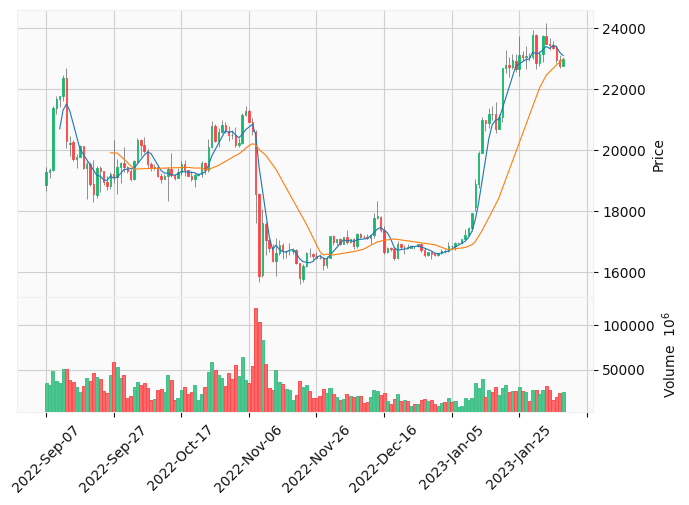

In [ ]:
import mplfinance as mpf

def displayStockChart(s : str, periodGraph :str):
    data = yfin.download(s,period=periodGraph)

    # Add MACD as subplot
    def MACD(data, window_slow, window_fast, window_signal):
        macd = pd.DataFrame()
        macd['ema_slow'] = data['Close'].ewm(span=window_slow).mean()
        macd['ema_fast'] = data['Close'].ewm(span=window_fast).mean()
        macd['macd'] = macd['ema_slow'] - macd['ema_fast']
        macd['signal'] = macd['macd'].ewm(span=window_signal).mean()
        macd['diff'] = macd['macd'] - macd['signal']
        macd['bar_positive'] = macd['diff'].map(lambda x: x if x > 0 else 0)
        macd['bar_negative'] = macd['diff'].map(lambda x: x if x < 0 else 0)
        return macd

    macd = MACD(data, 12, 26, 9)
    macd_plot  = [
        mpf.make_addplot((macd['macd']), color='#606060', panel=2, ylabel='MACD', secondary_y=False),
        mpf.make_addplot((macd['signal']), color='#1f77b4', panel=2, secondary_y=False),
        mpf.make_addplot((macd['bar_positive']), type='bar', color='#4dc790', panel=2),
        mpf.make_addplot((macd['bar_negative']), type='bar', color='#fd6b6c', panel=2),
    ]


    mpf.plot(data, type='candle', style='yahoo', mav=(5,20), volume=True)# addplot=macd_plot)

displayStockChart("BTC-USD","5mo")